<a href="https://colab.research.google.com/github/Rafat97/bengali-handwritten-digits-0-to-9-classification/blob/master/CSE_4238_Soft_Computing_Lab_Assignment_2_Exp_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Author info
<center>

| |  |
| ----------- | ----------- |
| ![Emdadul Haque Rafat](https://rafat97.github.io/static/c3688eb99d1fef50023a121e3abc5fa6/e8044/my-image.jpg)      | `Name:` Emdadul Haque<br /><br /> `Professional Status:` Student of Computer Science and Engineering <br /><br /> `Email:` rafathaque1997@gmail.com <br /><br /> `Website :` https://rafat97.github.io/ <br /><br />`Github:` https://github.com/Rafat97 <br /><br /> `Linkedin:` https://www.linkedin.com/in/rafat-haque-173131139/   |

</center>

# Drive mount code

In [ ]:
from google.colab import drive
drive.mount('./drive')

# Data Load From zip

In [ ]:
# import some importent library or packages 
import matplotlib.pyplot as plt
import warnings
import time,sys
import copy

import pandas as pd
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import pathlib
import shutil
from pathlib import Path
from collections import Counter
!pip install torchsummary
from torchsummary import summary

!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

warnings.filterwarnings('ignore')
torch.manual_seed(0)


  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=ad22ee385af9222282ca7eaf27bfb5cd691b0a7cfeee81f7ebbf2bfdd8e25352
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


## Download preprocessed dataset

In [ ]:
!gdown --id '1cml-H4UUJyY0hRoVeAynO8JjvWqa7FU1'

Downloading...
From: https://drive.google.com/uc?id=1cml-H4UUJyY0hRoVeAynO8JjvWqa7FU1
To: /content/PROCESSED_DATASET-170104028.zip
816MB [00:10, 80.3MB/s]


## Unzip the download dataset

In [ ]:
!unzip '/content/PROCESSED_DATASET-170104028.zip'

Streaming output truncated to the last 5000 lines.
  inflating: PROCESSED_DATASET-170104028/1/a17146.png  
  inflating: PROCESSED_DATASET-170104028/1/a05868.png  
  inflating: PROCESSED_DATASET-170104028/1/a09261.png  
  inflating: PROCESSED_DATASET-170104028/1/a03122.png  
  inflating: PROCESSED_DATASET-170104028/1/a06027.png  
  inflating: PROCESSED_DATASET-170104028/1/a02242.png  
  inflating: PROCESSED_DATASET-170104028/1/a08997.png  
  inflating: PROCESSED_DATASET-170104028/1/a05757.png  
  inflating: PROCESSED_DATASET-170104028/1/a09745.png  
  inflating: PROCESSED_DATASET-170104028/1/a09835.png  
  inflating: PROCESSED_DATASET-170104028/1/a18829.png  
  inflating: PROCESSED_DATASET-170104028/1/a18914.png  
  inflating: PROCESSED_DATASET-170104028/1/a11958.png  
  inflating: PROCESSED_DATASET-170104028/1/a03418.png  
  inflating: PROCESSED_DATASET-170104028/1/a14969.png  
  inflating: PROCESSED_DATASET-170104028/1/a05174.png  
  inflating: PROCESSED_DATASET-170104028/1/a18256.png

## Remove the zip file

In [ ]:
!rm '/content/PROCESSED_DATASET-170104028.zip'

# Import packages

In [ ]:
# import some importent library or packages 
import matplotlib.pyplot as plt
import warnings
import time,sys
import copy

import pandas as pd
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import pathlib
import shutil
from pathlib import Path
from collections import Counter
!pip install torchsummary
from torchsummary import summary

!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

warnings.filterwarnings('ignore')
torch.manual_seed(0)


# important variables

In [ ]:
base_dir = '/content/PROCESSED_DATASET-170104028' 
BATCH_SIZE = 32

# 28(model-1), 128(model-2), 224(model-3),
IMAGE_SIZE = 224
LEARNING_RATE = 0.01
TEST_SIZE = 0.2
OUTPUT_DIM=10

# Load Dataset 

In [ ]:
transform = transforms.Compose([
                                # transforms.ToPILImage(),

                                ## this is only for when model is 1
                                transforms.Grayscale(), 
                                
                                # transforms.RandomRotation(20,expand=True), ## adding random rotation 20deg
                                # torchvision.transforms.ColorJitter(hue=.05, saturation=.05), ## adding color filter
                                # transforms.RandomVerticalFlip(), ## adding vertical flip
                                # transforms.RandomHorizontalFlip(), ## adding horizontal flip
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

#load training dataset 
dataset = torchvision.datasets.ImageFolder(base_dir, transform=transform)
n = len(dataset) 
n_test = int(TEST_SIZE * n) # 10% validation
trainDataset, validDataSet = torch.utils.data.random_split(dataset,[n - n_test,n_test]) #random split dataset
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,) 
validationloader = torch.utils.data.DataLoader(validDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,) 
print("Length of the trainloader:", len(trainloader ) * BATCH_SIZE)
print("Length of the validationloader:", len(validationloader ) * BATCH_SIZE)

Length of the trainloader: 15776
Length of the validationloader: 3968


In [ ]:

# trainDataset = torchvision.datasets.FashionMNIST(root='./data', 
#                             train=True, 
#                             transform=transforms.ToTensor(),  # Normalize the image to [0-1] from [0-255]
#                             download=True)

# validDataSet = torchvision.datasets.FashionMNIST(root='./data', 
#                            train=False, 
#                            transform=transforms.ToTensor())

# '''
# MAKING DATASET ITERABLE
# '''

# trainloader = torch.utils.data.DataLoader(dataset=trainDataset, 
#                                            batch_size=BATCH_SIZE, 
#                                            shuffle=True)   # It's better to shuffle the whole training dataset! 

# validationloader = torch.utils.data.DataLoader(dataset=validDataSet, 
#                                           batch_size=BATCH_SIZE, 
#                                           shuffle=False)  

# print("Length of the trainloader:", len(trainloader ) * BATCH_SIZE)
# print("Length of the validationloader:", len(validationloader ) * BATCH_SIZE)

# Data basic info.

In [ ]:
dataset.class_to_idx # class map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [ ]:
print(dict(Counter(dataset.targets))) # count number of data in a class

{0: 1975, 1: 1963, 2: 1984, 3: 1976, 4: 1982, 5: 1965, 6: 1983, 7: 1960, 8: 1950, 9: 1964}


In [ ]:
train_classes = [label for _, label in trainDataset]
print(dict(Counter(train_classes)))

{4: 1547, 9: 1591, 3: 1597, 2: 1606, 1: 1582, 6: 1591, 5: 1564, 8: 1564, 7: 1559, 0: 1561}


In [ ]:
val_classes = [label for _, label in validDataSet]
print(dict(Counter(val_classes)))

{7: 401, 3: 379, 5: 401, 1: 381, 4: 435, 2: 378, 6: 392, 8: 386, 9: 373, 0: 414}


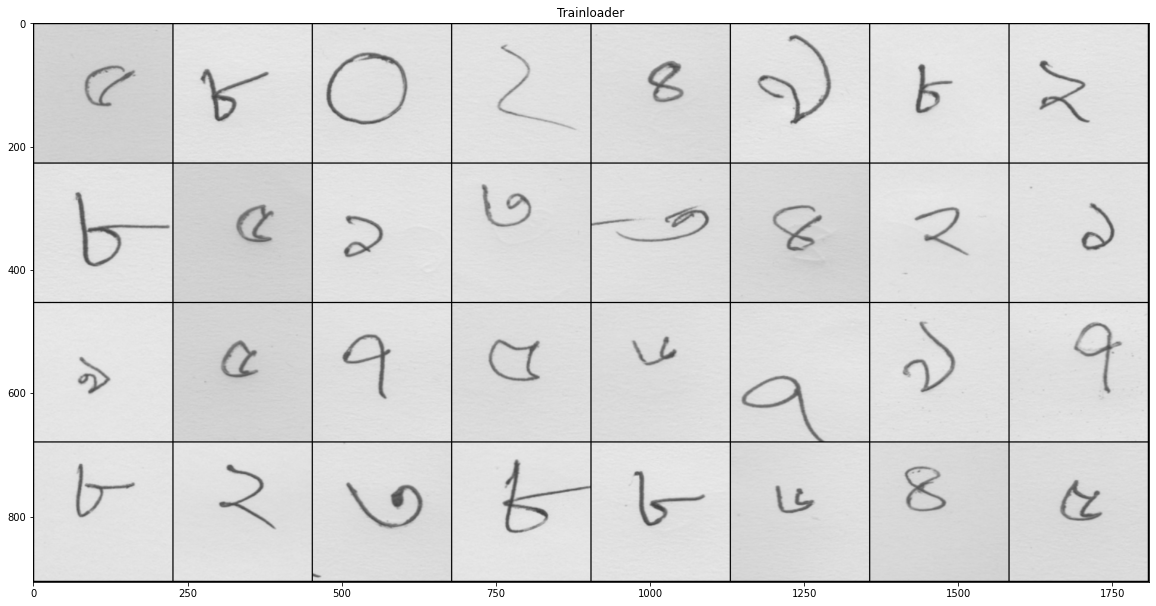

tensor([5, 8, 0, 2, 4, 9, 8, 2, 8, 5, 1, 3, 3, 4, 2, 1, 9, 5, 7, 5, 6, 7, 9, 7,
        8, 2, 3, 8, 8, 6, 4, 5])


In [ ]:
for image,label in trainloader:
  plt.figure(figsize=(20,20))
  grid_imge_gen = torchvision.utils.make_grid(image)
  plt.imshow(grid_imge_gen.permute(1, 2, 0).cpu())
  plt.title("Trainloader")
  plt.show()
  print(label)
  break

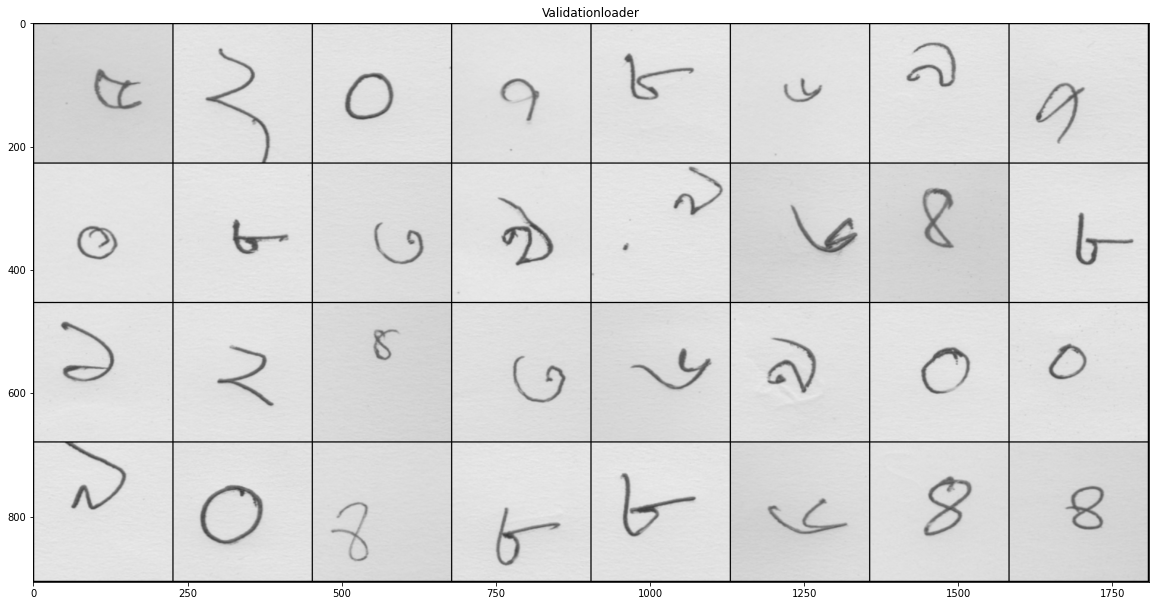

tensor([5, 2, 0, 7, 8, 6, 9, 7, 0, 8, 3, 9, 9, 6, 4, 8, 1, 2, 4, 3, 6, 9, 0, 0,
        9, 0, 4, 8, 8, 6, 4, 4])


In [ ]:
for image,label in validationloader:
  plt.figure(figsize=(20,20))
  grid_imge_gen = torchvision.utils.make_grid(image)
  plt.imshow(grid_imge_gen.permute(1, 2, 0).cpu())
  plt.title("Validationloader")
  plt.show()
  print(label)
  break

# Model Creation 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model 1

In [ ]:
'''
Model creation 
'''

class LIN_MODEL(torch.nn.Module): 
    def __init__(self,outDim):
        super(LIN_MODEL, self).__init__()

        self.fc_1 = torch.nn.Linear(784, 90)
        self.fc_2 = torch.nn.Linear(90, 50)
        self.fc_3 = torch.nn.Linear(50, 30)
        self.fc_4 = torch.nn.Linear(30, 18)
        self.fc_5 = torch.nn.Linear(18, 12)
        self.fc_6 = torch.nn.Linear(12, outDim)

        self.linear = torch.nn.Linear(784, outDim)
 
    def forward(self, x):

        x = x.view(-1, 28 * 28) 
        x = torch.nn.functional.relu(self.fc_1(x))
        x = torch.nn.functional.softmax(self.fc_2(x),dim=1)
        x = torch.nn.functional.relu(self.fc_3(x))
        x = torch.nn.functional.softmax(self.fc_4(x),dim=1)
        x = torch.nn.functional.relu(self.fc_5(x))
        x = self.fc_6(x)
        # x = torch.nn.functional.softmax(self.linear(x),dim=1)
        return x
        

model_1 = LIN_MODEL(OUTPUT_DIM).to(device)

summary( model_1, input_size=(1, 28, 28))
# select CPU or GPU as a device
print(model_1)


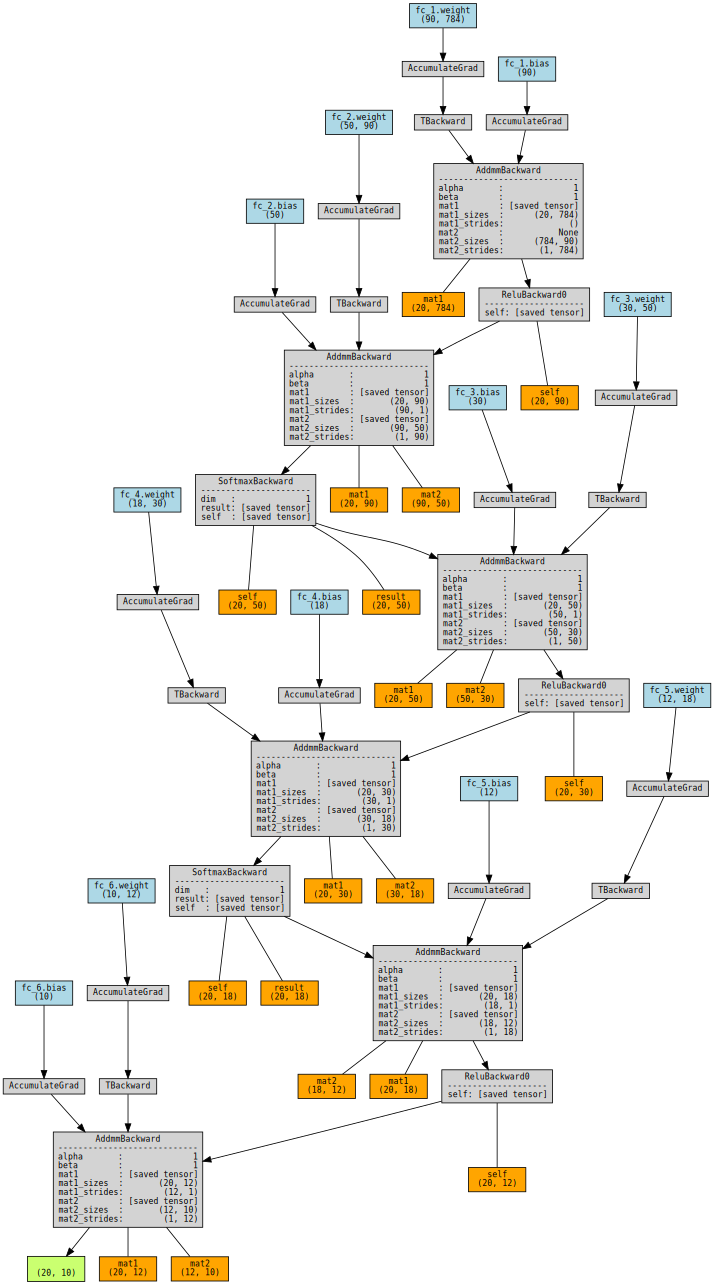

In [ ]:
x = torch.randn(BATCH_SIZE,1,28,28).to(device)
make_dot(model_1(x), params=dict(model_1.named_parameters()), show_attrs=True, show_saved=True)

In [ ]:
make_dot(model_1(x), params=dict(model_1.named_parameters()), show_attrs=True, show_saved=True).render("Model-1", format="png")

'Model-1.png'

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=LEARNING_RATE, )

# Start Tranning

## Save Model

In [ ]:
def save_model(
               MODEL_USED,
               SAVEPATH,
               epoch, 
               batch_size, 
               model,
               optimizer,
               image_size,
               tranning_loss=[],
               tranning_acc=[],
               validation_loss=[],
               validation_acc=[],
               learning_rate=0.001,
               meta_data=None):
  SAVEPATH += f"{MODEL_USED}-checkpoint-epoch-{epoch}.pt"
  save_obj = {
       'MODEL_USED':MODEL_USED,
       'batch_size':batch_size,
       'epoch': epoch,
       'model_full': model,
       'optimizer_full': optimizer,
       'model_state': model.state_dict(),
       'optimizer_state': optimizer.state_dict(),
       'image_size': image_size,
       'tranning_loss': tranning_loss,
       'tranning_acc': tranning_acc,
       'validation_loss': validation_loss,
       'validation_acc': validation_acc,
       'learning_rate':learning_rate,
       'meta_data':meta_data
       }

  torch.save(save_obj, SAVEPATH)

## Train function

In [ ]:
def train_model(start, end, 
                model_used ,
                model_save_path, 
                model, 
                criterion, 
                optimizer, 
                dataloaders,
                testloaders , 
                lernRate=0.001
                all_tranning_loss=[], all_validation_loss=[], all_tranning_accuracy=[], all_validation_accuracy=[]):
    since = time.time()
    num_epochs = end
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    phase = 'train'
    steps = 0

    for epoch in range(start,num_epochs):
          model.train()
          phase = 'tranning'
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)
          running_loss = 0.0
          running_corrects = 0

          for i,(inputs, labels) in enumerate(dataloaders):
                
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                # running_loss += loss.item() * inputs.size(0)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                

                print_val = f"Epoch: {epoch}/{num_epochs-1} Steps {steps} \t"
                print_val += f"running_loss : {(loss.item()):.6f}\t"
                print_val += f"running_corrects : {torch.sum(preds == labels.data)}\t"  
                print_val += f"total_corrects : {running_corrects}\t"  
                sys.stdout.write('\r' + str(print_val))
                steps += 1
          
          
          steps = 0
          epoch_loss = running_loss / len(dataloaders)
          epoch_acc = running_corrects.double().item() /len(dataloaders.dataset)
          all_tranning_loss.append(loss.item())
          all_tranning_accuracy.append(epoch_acc)
          
          
          print("\n")
          print("----------------------------Tranning Summary----------------------")
          print('{} Tranning Avg. Loss: {:.4f} Tranning Avg. Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
          print("-"*70)
          print("\n")

          print("Start Validation")
          model.eval()
          with torch.no_grad():
              phase = "validation"
              running_loss = 0.0
              running_corrects = 0
              for i,(inputs, labels) in enumerate(testloaders):
                  inputs, labels = inputs.to(device), labels.to(device)
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                    
                  running_loss += loss.item()
                  running_corrects += torch.sum(preds == labels.data)  

                  print_val = f"Steps {i} \t"
                  print_val += f"validation_running_loss : {(loss.item()):.6f}\t"
                  print_val += f"validation_running_corrects : {torch.sum(preds == labels.data)}\t"  
                  print_val += f"validation_total_corrects : {running_corrects}\t"  
                  sys.stdout.write('\r' + str(print_val))

              epoch_val_loss = running_loss / len(testloaders)
              epoch_val_acc = running_corrects.double().item() /len(testloaders.dataset)
              all_validation_loss.append(epoch_val_loss)
              all_validation_accuracy.append(epoch_val_acc)

              print()
              print("----------------------------Validation Summary-----------------")
              print('{} Validation Avg. Loss: {:.4f} Validation Avg. Acc: {:.4f}'.format(
                    phase, epoch_val_loss, epoch_val_acc))
              print("------------------------------------------------------------")


          model.train()
          
          print("-------Start Model Save----\n\n")
          save_model(model_used,
                     model_save_path,
                     epoch, 
                     len(dataloaders),
                     model,
                     optimizer,
                     IMAGE_SIZE,
                     tranning_loss=all_tranning_loss,
                     tranning_acc= all_tranning_accuracy,
                     validation_loss=all_validation_loss,
                     validation_acc=all_validation_accuracy,
                     learning_rate=lernRate)
          # break
      
    print("Complete Train")
          ## deep copy the model
          # if phase == 'val' and epoch_acc > best_acc:
          #       best_acc = epoch_acc
          #       best_model_wts = copy.deepcopy(model.state_dict())

    print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 

## Start Train

In [ ]:
# 1 (26 - 1 * 28 * 28) (own) (FMNIST)
# 1_2 (300 - 1 * 28 * 28) (own) (FMNIST)
# 1_3 (300 - 1 * 28 * 28) (own) (FMNIST)

# 2 (100 - 1 * 128 * 128) (FMNIST) 
# 2 (100 - 1 * 128 * 128) (own) 
# 2 (100 - 3 * 128 * 128) (own) 

# 3 (25 - 1 * 128 * 128) (FMNIST) 


In [ ]:
!mkdir 'EXP-3-COLOR-OWN'
%cd '/content'

/content


In [ ]:
from pathlib import Path

START=0
model_save_path = './EXP-3-COLOR-OWN/' # must give `/` for the folder directory

model_used= 'EXPERIMENT_MODEL_3_RSNET_COLOR'
model_ft = model_1
# model_ft = model_1_2
# model_ft = model_1_3
# model_ft = model_2
# model_ft = model_3
optimizer_ft = optimizer
all_tranning_loss = [];
all_validation_loss = [];
all_tranning_accuracy = []; 
all_validation_accuracy = [];

load_saved_model='/content/EXP-1-2-OWN/EXPERIMENT_MODEL_1_2-checkpoint-epoch-187.pt'
p = Path(load_saved_model)
if len(load_saved_model) > 1 and p.exists():
  loadedModel = torch.load(load_saved_model, map_location=device)
  model_used = loadedModel['MODEL_USED']
  model_ft =  loadedModel['model_full']
  model_ft.load_state_dict(loadedModel['model_state'])
  optimizer_ft = loadedModel['optimizer_full']
  optimizer_ft.load_state_dict(loadedModel['optimizer_state'] )
  START = loadedModel['epoch'] + 1 
  all_tranning_loss = loadedModel['tranning_loss'] 
  all_validation_loss = loadedModel['validation_loss'] 
  all_tranning_accuracy = loadedModel['tranning_acc'] 
  all_validation_accuracy = loadedModel['validation_acc']

END=25
trainloader= trainloader
testloader = validationloader

In [ ]:
train_model(START, END,model_used, model_save_path, model_ft, criterion, optimizer_ft, trainloader, testloader, lernRate=0.001
            all_tranning_loss, 
            all_validation_loss, 
            all_tranning_accuracy, 
            all_validation_accuracy)

Epoch 0/24
----------
Epoch: 0/24 Steps 492 	running_loss : 0.519452	running_corrects : 15	total_corrects : 12834	

----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 0.8514 Tranning Avg. Acc: 0.8142
----------------------------------------------------------------------


Start Validation
Steps 123 	validation_running_loss : 0.740379	validation_running_corrects : 3	validation_total_corrects : 3605	
----------------------------Validation Summary-----------------
validation Validation Avg. Loss: 0.4310 Validation Avg. Acc: 0.9150
------------------------------------------------------------
-------Start Model Save----


Epoch 1/24
----------
Epoch: 1/24 Steps 492 	running_loss : 0.671391	running_corrects : 14	total_corrects : 14192	

----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 0.4110 Tranning Avg. Acc: 0.9004
----------------------------------------------------------------------


Start Valida

In [ ]:
# !cp  '/content/drive/MyDrive/MY_COURSE/4.2/CSE-4238-Soft Computuing/Assignment 2/OWN/EXP-1-2-OWN.zip' './'
# !unzip '/content/EXP-1-2-OWN.zip' 

In [ ]:
# !mkdir 'EXP-2'

In [ ]:
!zip -r 'EXP-3-COLOR-OWN.zip' 'EXP-3-COLOR-OWN' 

updating: EXP-3-COLOR-OWN/ (stored 0%)
updating: EXP-3-COLOR-OWN/EXPERIMENT_MODEL_3_RSNET_COLOR-checkpoint-epoch-0.pt


zip error: Interrupted (aborting)


In [ ]:
# !mv '/content/EXPERIMENT_MODEL_2-checkpoint-epoch-26.pt' '/content/EXP-2'

In [ ]:
# !rm -rf '/content/EXP-1/EXP-1/drive/MyDrive/MY_COURSE/4.2/CSE-4238-Soft Computuing/Assignment 2/EXP-1/drive'

In [ ]:
!cp -rfv '/content/EXP-1-3-OWN.zip'  '/content/drive/Shareddrives/Test shared drive'

'/content/EXP-3-GRAY-OWN.zip' -> '/content/drive/Shareddrives/Test shared drive/EXP-3-GRAY-OWN.zip'


In [ ]:
!cp -rfv '/content/EXP-1-3-OWN.zip'  '/content/drive/MyDrive/MY_COURSE/4.2/CSE-4238-Soft Computuing/Assignment 2/OWN'

'/content/EXP-1-3-OWN.zip' -> '/content/drive/MyDrive/MY_COURSE/4.2/CSE-4238-Soft Computuing/Assignment 2/OWN/EXP-1-3-OWN.zip'


In [ ]:
# class CNN(torch.nn.Module): 
#     def __init__(self):
#         super(CNN, self).__init__()

#         #initializing 4 convolution layer
#         self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
#         self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
#         self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
#         self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)

#         #initializing dropout 
#         self.dropout = torch.nn.Dropout(0.2)

#         #initializing dropout 
#         self.pool= torch.nn.MaxPool2d(2,2)
 
#         #initializing linear 
#         self.fc1 = torch.nn.Linear(256 * 5 * 5, 512)
#         self.fc2 = torch.nn.Linear(512, 64)
#         self.fc3 = torch.nn.Linear(64, 32)
#         self.fc4 = torch.nn.Linear(32, 10)
 
#     def forward(self, x):
#         x = self.pool(torch.nn.functional.relu(self.conv1(x))) #sending input into 1st convolution layer,then to relu ,then to pooling layer , param = ((3*3*3)+1)*16 = 448
#         x = self.pool(torch.nn.functional.relu(self.conv2(x))) #sending previous output into 2nd convolution layer,then to relu ,then to pooling layer, param = ((3*3*16)+1)*32 = 4640 
#         x = self.dropout(x) #dropout unnecessary output
#         x = self.pool(torch.nn.functional.relu(self.conv3(x)))
#         x = self.pool(torch.nn.functional.relu(self.conv4(x)))
#         x = self.dropout(x)
#         x = x.view(-1, 256 * 5 * 5) # for flatten layer
#         x = torch.nn.functional.relu(self.fc1(x))
#         x = torch.nn.functional.relu(self.fc2(x))
#         x = torch.nn.functional.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x
        
# #select CPU or GPU as a device
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device
# model = CNN().to(device)
# print(model)